In [49]:
import os
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigs

In [50]:
# 计算成对的欧式距离
def pairwise_distances(Data):
    return np.sqrt(np.sum((Data[:, None] - Data) ** 2, axis=2))

def k_nearest_neighbors(Data, n_neighbors):
    dist_matrix = pairwise_distances(Data)
    return np.argsort(dist_matrix, axis=1)[:, 1:n_neighbors + 1]

In [51]:
def compute_density_based_radius(Data, target_density):
    n = Data.shape[0]  # 数据集的大小
    dist_matrix = pairwise_distances(Data)  # 计算成对的欧式距离
    density_based_radius = np.zeros(n)  # 存储每个数据点的密度基础邻域半径
    for i in range(n):  # 计算每个数据点的密度基础邻域半径
        # 计算每个数据点到其他点的距离并排序
        distances = np.sort(dist_matrix[i])
        # 计算以当前点为圆心，距离为当前距离的圆周上的点的数量
        num_points_within_distance = np.array([np.sum(distances <= d) for d in distances])
        # 计算密度基础邻域半径，使得圆周上的点的数量接近目标密度
        density_based_radius[i] = distances[np.argmin(np.abs(num_points_within_distance - target_density))]
    return density_based_radius

# 以每个点k最近邻的平均距离作为每个数据点的半径
def compute_knn_average_radius(Data, dist_matrix, knn_matrix):
    n = Data.shape[0]
    avg_distances = np.zeros(n)
    for i in range(n):
        knn_indices = knn_matrix[i] # 第i个数据点的k个最近邻的索引
        knn_distances = [dist_matrix[i, idx] for idx in knn_indices] # 第i个数据点到k个最近邻的距离
        avg_distances[i] = np.mean(knn_distances) # 第i个数据点的k个最近邻的平均距离
    return avg_distances

In [52]:
import heapq

# 使用优先队列（堆）实现 Dijkstra 算法
def dijkstra_shortest_path(graph, start):
    n = graph.shape[0]
    distances = np.full(n, np.inf)
    distances[start] = 0
    pq = [(0, start)]  # 优先队列，存储节点和对应的距离
    while pq:
        dist, current = heapq.heappop(pq)  # 弹出距离最小的节点
        if dist > distances[current]:
            continue
        for neighbor, weight in enumerate(graph[current]):
            if weight > 0 and dist + weight < distances[neighbor]:
                distances[neighbor] = dist + weight
                heapq.heappush(pq, (dist + weight, neighbor))  # 更新距离并入队
    return distances

# 以每个点到其他所有点的最短路径的平均值作为每个数据点的半径
def compute_avg_shortest_path(Data, knn_matrix):
    dist_matrix = pairwise_distances(Data)
    # 基于k最近邻图构建临时邻接矩阵 adjacency_matrix
    adjacency_matrix = np.zeros((len(Data), len(Data)))
    for i in range(len(Data)):
        for j in knn_matrix[i]:
            adjacency_matrix[i][int(j)] = dist_matrix[i][int(j)]
            adjacency_matrix[int(j)][i] = dist_matrix[int(j)][i]
    # 使用迪杰斯特拉算法计算最短路径并得到成对的测地距离 shortest_paths
    shortest_paths = np.zeros((len(Data), len(Data)))
    for i in range(len(Data)):
        shortest_paths[i] = dijkstra_shortest_path(adjacency_matrix, i)
    # 计算每个数据点的平均最短路径
    avg_shortest_paths = np.zeros(len(Data))
    for i in range(len(Data)):
        avg_shortest_paths[i] = np.mean(shortest_paths[i])
    return avg_shortest_paths

In [53]:
# 以每个点到其他所有点的平均值作为每个数据点的平均邻域半径
def compute_avg_radius(Data, distances): 
    n = Data.shape[0] # 数据集的大小
    radius = np.zeros(n) # 存储每个数据点的平均邻域半径
    for i in range(n): # 计算每个数据点的平均邻域半径
        avg_radius = np.mean(distances[i]) # 每个数据点到其他所有点的平均值
        radius[i] = avg_radius # 存储每个数据点的平均邻域半径
    return radius

In [54]:
Pi = 3.14159265358979323846

def knn_graph(Data, method, k):
    """
    计算k近邻图

    Args:
    - Data: 输入数据集的矩阵，每行代表一个样本点
    - k: 最近邻的数量

    Returns:
    - knn_adjacency_matrix: k近邻图的邻接矩阵，W[i, j]表示样本点i和j之间是否相连
    """
    # 获取样本点的数量
    n = Data.shape[0]
    # 初始化k近邻图的邻接矩阵
    knn_adjacency_matrix = np.zeros((n, n))  
    # 计算欧式距离矩阵
    distances = np.sqrt(np.sum((Data[:, None] - Data) ** 2, axis=2))
    if method == 'epsilon':
        return knn_adjacency_matrix, distances
    # 获取每个样本点的最近邻索引
    indices = np.argsort(distances, axis=1)[:, 1:k+1]
    # 构建k近邻图的权重矩阵
    # 遍历每个样本点的最近邻索引
    for i in range(n):
        knn_adjacency_matrix[i, indices[i]] = 1
        knn_adjacency_matrix[indices[i], i] = 1
    return knn_adjacency_matrix, distances

# 计算k最近邻索引矩阵或epsilon邻接矩阵
def compute_neighborhood_matrix(Data, method, k):
    n = len(Data)
    knn_adjacency_matrix, distances = knn_graph(Data, method, k)
    if method == 'knn':
        np.savetxt('knn_adjacency_matrix.csv', knn_adjacency_matrix, delimiter = ',')
        return knn_adjacency_matrix, distances
    elif method == 'epsilon':
        adjacency_matrix = np.zeros((n, n))
        radius = compute_avg_radius(Data, distances)  # 计算每个数据点的邻域半径
        for i in range(n):  # 对于数据集中的每个样本点 i
            distances = np.sqrt(np.sum((Data[i] - Data) ** 2, axis=1))
            neighbors = []
            for j in range(n):  # 初始化 neighbors 列表
                if (distances[j] <= radius[i]) and (len(neighbors) <= n/2): # 如果样本点 j 在第i个样本点的epsilon邻域内
                    neighbors.append(j)
            adjacency_matrix[i, neighbors] = 1
            adjacency_matrix[neighbors, i] = 1
        return adjacency_matrix, distances

In [55]:
# 将k最近邻矩阵的邻接矩阵和 epsilon 邻域矩阵相结合得到最佳邻接矩阵
def Best_adjacency_matrix(Data, k):
    n = len(Data)
    best_adjacency_matrix = np.zeros((n, n))
    # 计算k最近邻矩阵的邻接矩阵和 epsilon 邻域矩阵
    knn_adjacency_matrix, distances = compute_neighborhood_matrix(Data, 'knn', k)
    epsilon_adjacency_matrix, distances = compute_neighborhood_matrix(Data, 'epsilon', k)
    # 结合两种邻接矩阵得到最佳邻接矩阵
    best_adjacency_matrix = np.logical_and(knn_adjacency_matrix, epsilon_adjacency_matrix)
    return best_adjacency_matrix, distances

In [56]:
# 构建基于热核方法的权重矩阵
def construct_weight_matrix(Data, k, t):
    n = len(Data)
    Weight_matrix = np.zeros((n, n))
    adjacency_matrix, distances = Best_adjacency_matrix(Data, k)
    for i in range(n):  # 对于数据集中的每个样本点 i
        for j in range(n):  # 对于数据集中的每个样本点 j
            if adjacency_matrix[i, j] == 1:  # 如果样本点 j 在第i个样本点的epsilon邻域内
                distance = np.linalg.norm(Data[i] - Data[j])  # 计算样本点 i 和 j 之间的距离（欧式距离）
                Weight_matrix[i, j] = np.exp(-distance ** 2 / t) # 使用热核方法计算权重
                Weight_matrix[j, i] = np.exp(-distance ** 2 / t) # 邻接矩阵为对称矩阵
    # 计算全局相似度
    '''
    修正权重矩阵的原理是利用全局相似度来修正局部相似度得到的权重矩阵，以使得整个权重矩阵更加平滑和连续。
    '''
    Weight_matrix += np.exp(-distances ** 2 / t)
    return Weight_matrix    

In [57]:
def LPP(Data, d, k, t):
    """
    进行LPP算法，得到特征映射后的数据集

    Args:
    - Data: 输入数据集的矩阵，每行代表一个样本点
    - d: 降维后的维度
    - k: 最近邻的数量
    - t: 高斯核函数的参数

    Returns:
    - selected_eigenvectors: 特征映射后的数据集
    """
    # Step 1: 计算权重矩阵
    Weight_matrix = construct_weight_matrix(Data, k, t)
    # Step 2: 计算度矩阵和拉普拉斯矩阵
    Degree_matrix = np.diag(np.sum(Weight_matrix, axis=1))
    Laplacian_matrix = Degree_matrix - Weight_matrix
    # Step 3: 进行特征映射
    eigenvalues, eigenvectors = eigs(Laplacian_matrix, k=d+1, which='SR')
    sorted_indices = np.argsort(eigenvalues.real)
    selected_indices = sorted_indices[1:d + 1]
    selected_eigenvectors = eigenvectors.real[:, selected_indices]
    return selected_eigenvectors

In [58]:
# 示例数据
Data = np.load('./swiss roll-1000.npy')
# 将 X 格式化为 (n_samples, n_features)
Data_T = np.transpose(Data)
'''
# 绘制三维数据集
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(Data[0, :], Data[1, :], Data[2, :], c=plt.cm.jet((Data[0, :]**2 + Data[2, :]**2) / 100), s=200, lw=0, alpha=1)
ax.set_xlim(np.min(Data[0, :]), np.max(Data[0, :]))
ax.set_ylim(np.min(Data[1, :]), np.max(Data[1, :]))
ax.set_zlim(np.min(Data[2, :]), np.max(Data[2, :]))
plt.title('Data - '+ str(Data.shape[1]) + ' points', size=30)
ax.axis("off")
'''

'\n# 绘制三维数据集\nfig = plt.figure(figsize=(14,10))\nax = fig.add_subplot(111, projection="3d")\nax.scatter(Data[0, :], Data[1, :], Data[2, :], c=plt.cm.jet((Data[0, :]**2 + Data[2, :]**2) / 100), s=200, lw=0, alpha=1)\nax.set_xlim(np.min(Data[0, :]), np.max(Data[0, :]))\nax.set_ylim(np.min(Data[1, :]), np.max(Data[1, :]))\nax.set_zlim(np.min(Data[2, :]), np.max(Data[2, :]))\nplt.title(\'Data - \'+ str(Data.shape[1]) + \' points\', size=30)\nax.axis("off")\n'

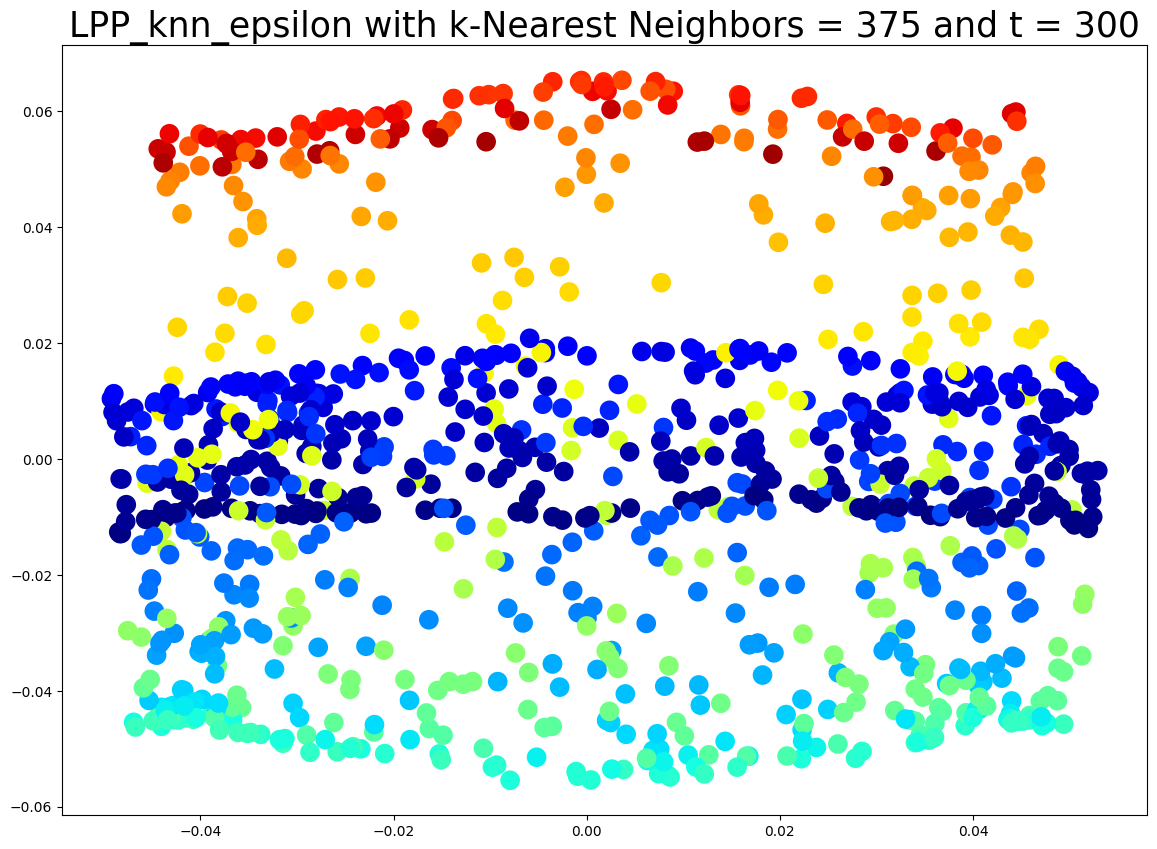

In [59]:
# 绘制及保存投影图
if not os.path.exists('output'):
    os.makedirs('output')
plt.figure(figsize=(14, 10))
k = 375
t= 300
lpp_embeddings = LPP(Data_T, d=2,  k=k, t=t)
plt.title('LPP_knn_epsilon with k-Nearest Neighbors = ' + str(k) + ' and t = ' + str(t), size=25)
file_name = 'LPP_knn_epsilon' + str(k) + '_t=' + str(t) + '.png'
file_path = os.path.join('.', 'output', file_name)
plt.scatter(lpp_embeddings[:, 0], lpp_embeddings[:, 1], c=plt.cm.jet((Data_T[:, 0] ** 2 + Data_T[:, 2] ** 2) / 100),s=200, lw=0, alpha=1)
plt.savefig(file_path)
plt.show()

In [60]:
# MDS 算法实现
def MDS(distances, n_components):
    n = distances.shape[0]  # 获取数据集的大小
    J = np.eye(n) - np.ones((n, n)) / n  # 计算中心化矩阵 J
    B = -0.5 * J.dot(distances ** 2).dot(J)  # 计算矩阵 B
    eigenvalues, eigenvectors = np.linalg.eigh(B)  # 计算特征值和特征向量

    # 对特征值和特征向量进行排序
    indices = np.argsort(eigenvalues)[::-1]  # 获取特征值降序排列的索引
    eigenvalues = eigenvalues[indices]  # 根据索引重新排序特征值
    eigenvectors = eigenvectors[:, indices]  # 根据索引重新排序特征向量

    # 选择前 n_components 个特征值和对应的特征向量
    eigenvalues = eigenvalues[:n_components]  # 选择前 n_components 个特征值
    eigenvectors = eigenvectors[:, :n_components]  # 选择对应的特征向量

    # 计算降维后的结果
    embeddings = eigenvectors.dot(np.diag(np.sqrt(eigenvalues)))  # 计算降维后的嵌入结果
    return embeddings  # 返回嵌入结果

def LPP_Isomap(Data, n_components, n_neighbors):
    # 使用迪杰斯特拉算法计算最短路径并得到成对的测地距离 shortest_paths
    shortest_paths = np.zeros((len(Data), len(Data)))
    for i in range(len(Data)):
        shortest_paths[i] = dijkstra_shortest_path(Best_adjacency_matrix(Data, n_neighbors), i)
    embeddings = MDS(shortest_paths, n_components)
    return embeddings
'''
Embeddings = LPP_Isomap(Data_T, n_components = 2, n_neighbors = 10)
# 绘制 Isomap 投影图
plt.figure(figsize=(14,10))
plt.scatter(Embeddings[:, 0], Embeddings[:, 1], c=plt.cm.jet((Data_T[:,0]**2+Data_T[:,2]**2)/100), s=200, lw=0, alpha=1)
plt.title('Isomap with k-Nearest Neighbors = ' + str(n_neighbors), size=30)
plt.axis("off")
plt.show()
'''

'\nEmbeddings = LPP_Isomap(Data_T, n_components = 2, n_neighbors = 10)\n# 绘制 Isomap 投影图\nplt.figure(figsize=(14,10))\nplt.scatter(Embeddings[:, 0], Embeddings[:, 1], c=plt.cm.jet((Data_T[:,0]**2+Data_T[:,2]**2)/100), s=200, lw=0, alpha=1)\nplt.title(\'Isomap with k-Nearest Neighbors = \' + str(n_neighbors), size=30)\nplt.axis("off")\nplt.show()\n'